# Efecto Croma (pantallas verdes)

El efecto Croma (pantalla verde) es una técnica utilizada en la postproducción
de video y fotografía para combinar dos imágenes o videos en una sola.
Seguramente has visto cómo se graban películas de ciencia ficción o programas de
televisión donde los actores interactúan con un fondo que no está presente; esto
se logra grabando a los actores frente a una pantalla verde y luego reemplazando
el color verde por el fondo deseado.

En este cuaderno vamos a implementar una versión simplificada del efecto Croma
utilizando la técnica de umbralización en scikit-image.

In [19]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np

Primero carguemos una imagen de un actor frente a una pantalla verde y una
imagen de un fondo que queremos utilizar.

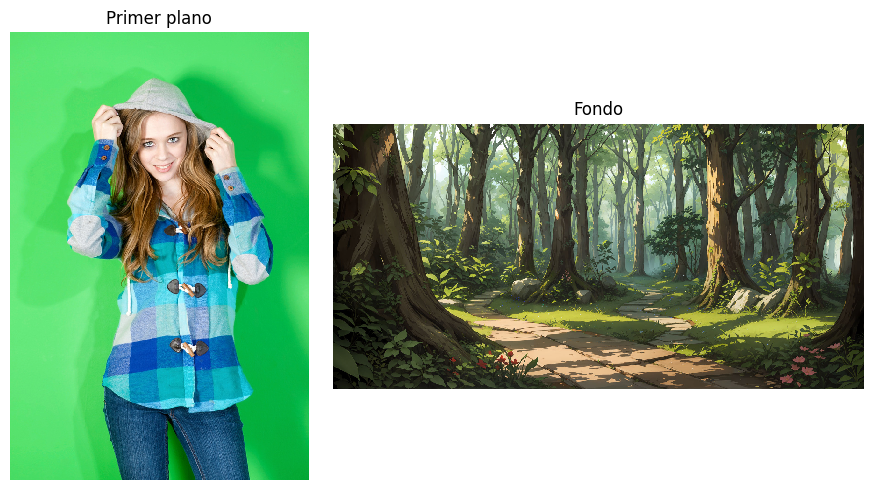

In [20]:
ruta_primer_plano = 'pantallas/Girl_in_front_of_a_green_background.jpg'
ruta_fondo = 'pantallas/enchanted_forest_background.jpg'

primer_plano = ski.util.img_as_float64(ski.io.imread(ruta_primer_plano))
fondo = ski.util.img_as_float64(ski.io.imread(ruta_fondo))
# Reescalar el fondo para que tenga la misma altura que el primer plano
fondo = ski.transform.resize(fondo, (primer_plano.shape[0], fondo.shape[1]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ski.io.imshow(primer_plano, ax=ax[0])
ski.io.imshow(fondo, ax=ax[1])

ax[0].set_title('Primer plano')
ax[0].axis('off')
ax[1].set_title('Fondo')
ax[1].axis('off')
fig.tight_layout()

Nuestra primera tarea es identificar una región de la imagen que tenga el color
llave (verde en este caso).
Nuestro algoritmo es muy simple: vamos a tomar la distancia euclidiana entre
cada píxel y el color llave en el espacio de color RGB.
Dado que tenemos dos píxeles $p = (r_p, g_p, b_p)$ y $q = (r_q, g_q, b_q)$, la
distancia euclidiana entre ellos es:

$$d(p, q) = \sqrt{(r_p - r_q)^2 + (g_p - g_q)^2 + (b_p - b_q)^2}$$

Si sabes un poco de álgebra lineal, puedes ver que esto es equivalente a la
norma de la diferencia entre los dos vectores.

$$d(p, q) = ||p - q|| = \sqrt{(p - q) \cdot (p - q)}$$

Cuando la distancia es cero, los dos colores son idénticos; de esta manera
podemos identificar los píxeles que son verdes o cercanos al verde.

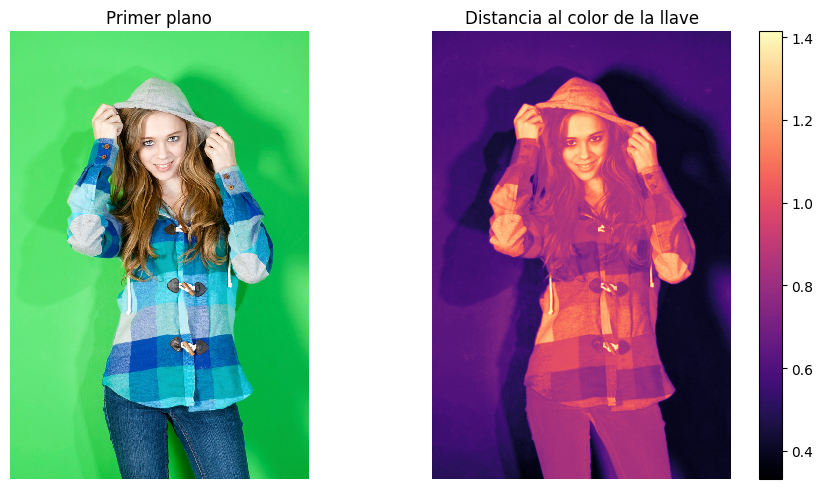

In [21]:
llave = np.array([0.0, 1.0, 0.0], dtype=np.float64)

# Calcular la distancia euclidiana entre el color de cada pixel del primer plano
# y el color de la llave
distancia = np.linalg.norm(primer_plano - llave, axis=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ski.io.imshow(primer_plano, ax=ax[0])
ax[0].set_title('Primer plano')
ax[0].axis('off')
ax[1].imshow(distancia, cmap='magma')
ax[1].set_title('Distancia al color de la llave')
ax[1].axis('off')
# Mostrar barra de color para la distancia
fig.colorbar(ax[1].imshow(distancia, cmap='magma'), ax=ax[1])
fig.tight_layout()

Podemos dividir este mapa de distancias en tres regiones:
- Las que están por debajo de un umbral son los píxeles que definitivamente son
  verdes y queremos reemplazar.
- Las que están por encima de un umbral son los píxeles que definitivamente no
  son verdes y queremos mantener.
- Los valores que están entre estos dos umbrales los queremos reemplazar con
  una interpolación entre el color llave y el color original.

Esta división nos dará lo que se conoce como una *máscara* que nos dice qué
píxeles queremos reemplazar y cuáles no (o qué tanto queremos reemplazarlos).
Cada píxel en la máscara tiene un valor entre 0 y 1, donde 0 significa que no
queremos reemplazar el píxel y 1 significa que queremos reemplazarlo por
completo.

Sea $\mathit{clip}(x, a, b)$ la función que toma un valor $x$ y lo ajusta a
los límites $a$ y $b$.

$$\mathit{clip}(x, a, b) = \begin{cases}
a & \text{si } x < a \\
b & \text{si } x > b \\
x & \text{en otro caso}
\end{cases}$$

Sea $D$ la matriz de distancias y los umbrales $0 \le t_{\min} < t_{\max}$, y
$\gamma > 0$ el factor de interpolación.
La máscara $M$ se puede calcular como:

$$\begin{align*}
M_{i, j} &= \mathit{clip}\left(1 - \frac{D_{i, j} - t_{\min}}{t_{\max} - t_{\min}},0,1\right)^\gamma \\
         &= \mathit{clip}\left(\frac{t_{\max} - D_{i, j}}{t_{\max} - t_{\min}},0,1\right)^\gamma
\end{align*}$$

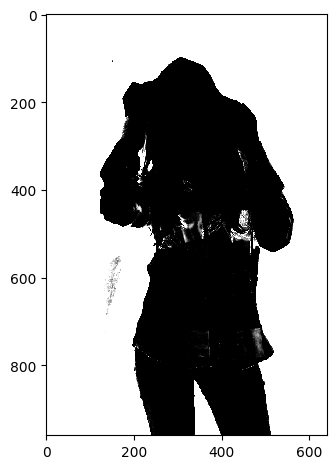

In [22]:
distancia_min = 0.71
distancia_max = 0.8
gamma = 2.2

mascara = (
    np.clip((distancia_max - distancia) / (distancia_max - distancia_min), 0, 1)
    ** gamma
)

ski.io.imshow(mascara, cmap="gray")

Con la máscara $M$ podemos combinar la imagen original $I$ con la imagen de
fondo $B$ para obtener la imagen final $F$.

$$F_{i, j} = M_{i, j} \cdot I_{i, j} + (1 - M_{i, j}) \cdot B_{i, j}$$

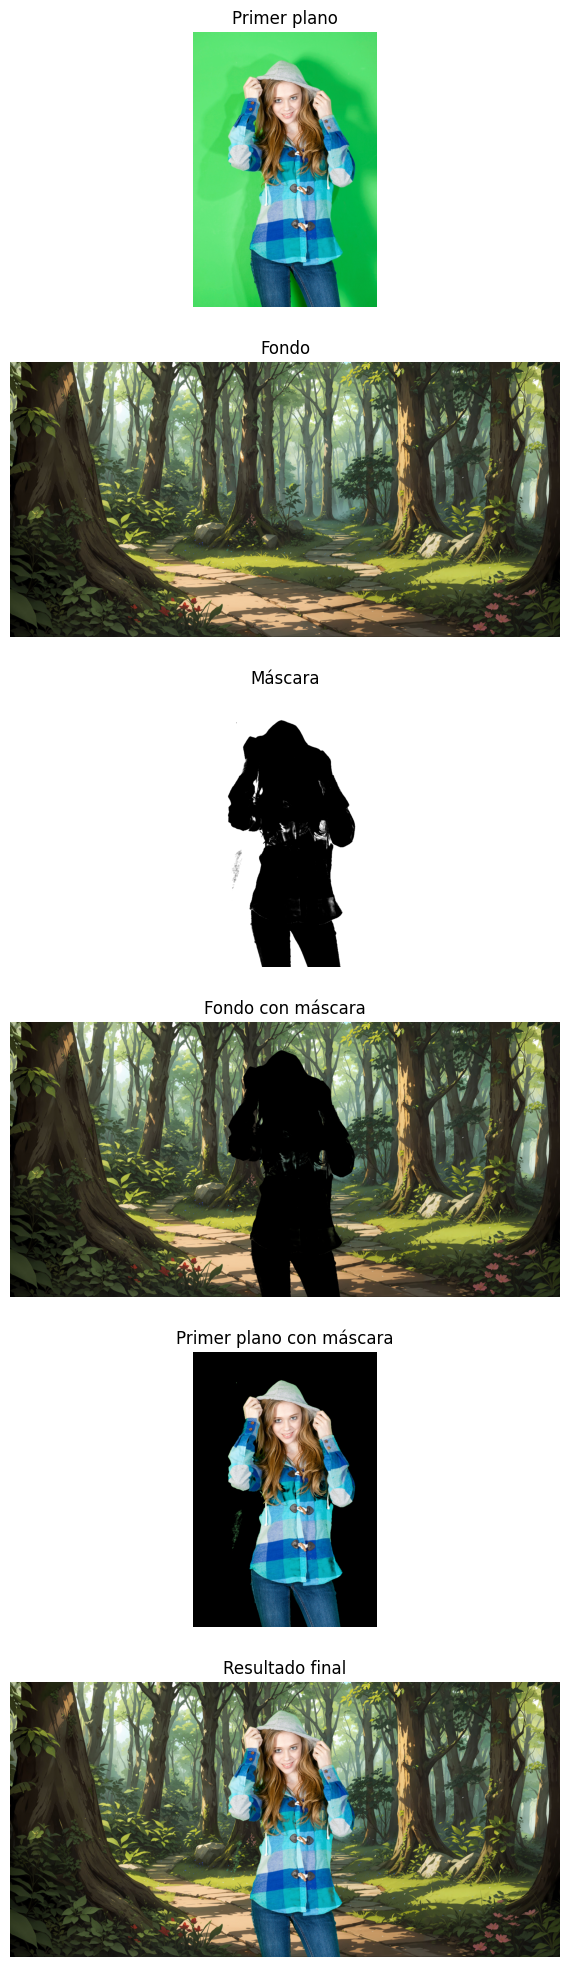

In [23]:
# La distancia actúa como una máscara para combinar el primer plano y el fondo
# de forma suave. Vamos a centrar la imagen del primer plano en el fondo
x_0 = (fondo.shape[1] - primer_plano.shape[1]) // 2
x_1 = x_0 + primer_plano.shape[1]
y_0 = (fondo.shape[0] - primer_plano.shape[0]) // 2
y_1 = y_0 + primer_plano.shape[0]
combinado = fondo.copy()

# Aplicar la máscara al fondo
combinado[y_0:y_1, x_0:x_1] *= mascara[:, :, None]
fondo_enmascarado = combinado.copy()

# Combinar el primer plano y el fondo
primer_plano_enmascarado = primer_plano * (1 - mascara[:, :, None])
combinado[y_0:y_1, x_0:x_1] += primer_plano_enmascarado

fig, ax = plt.subplots(6, 1, figsize=(10, 25))
ax[0].imshow(primer_plano)
ax[0].set_title('Primer plano')
ax[1].imshow(fondo)
ax[1].set_title('Fondo')
ax[2].imshow(mascara, cmap='gray')
ax[2].set_title('Máscara')
ax[3].imshow(fondo_enmascarado)
ax[3].set_title('Fondo con máscara')
ax[4].imshow(primer_plano_enmascarado)
ax[4].set_title('Primer plano con máscara')
ax[5].imshow(combinado)
ax[5].set_title('Resultado final')

for ax_i in ax:
    ax_i.axis('off')